In [1]:
import numpy as np
import torch
import gdown
import os
import zipfile  


if torch.cuda.is_available():
    print(f"✅ GPU is available: {torch.cuda.get_device_name(0)}")
    print(f"🔥 Running on: {torch.device('cuda')}")
else:
    print("❌ GPU not available, using CPU.")


FILE_ID = "19MBh9JIJTxYIPAeO7G5RML5_ddjJ1Cpa"  
ZIP_PATH = "downloaded.zip" 
BASE_PATH = "../data/" 
PIXEL_CLOUD_PATH = os.path.join(BASE_PATH, "pixel_cloud/") 
SKOGSSTYRELSEN = os.path.join(BASE_PATH, "skogsstyrelsen-data/")  

def download_file():
    """Downloads the file from Google Drive if it doesn't exist."""
    if not os.path.exists(ZIP_PATH):
        print(f"📥 Downloading dataset to '{ZIP_PATH}'...")
        gdown.download(f"https://drive.google.com/uc?export=download&id={FILE_ID}", ZIP_PATH, quiet=False)
        print("✅ Download complete!")
    else:
        print(f"✅ File '{ZIP_PATH}' already exists. Skipping download.")

def extract_zip():
    """Extracts the ZIP file into the respective folders and deletes the ZIP file after extraction."""

    if not os.path.exists(ZIP_PATH):
        print(f"❌ Error: '{ZIP_PATH}' not found. Cannot extract.")
        return

    if not zipfile.is_zipfile(ZIP_PATH):
        print("❌ Error: The downloaded file is not a valid ZIP archive.")
        return

    print(f"📂 Extracting '{ZIP_PATH}' into '{BASE_PATH}'...")
    

    os.makedirs(PIXEL_CLOUD_PATH, exist_ok=True)

    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(BASE_PATH)

    print("✅ Extraction complete!")
    os.remove(ZIP_PATH)
    print(f"🗑️ Deleted ZIP file '{ZIP_PATH}' after extraction.")

def list_files():
    """Lists extracted files for verification."""
    print("\n📁 Extracted files in CLOUD_PATH:")
    for root, dirs, files in os.walk(SKOGSSTYRELSEN):
        for file in files:
            print(f" - {os.path.join(root, file)}")

    print("\n📁 Extracted files in PIXEL_CLOUD_PATH:")
    for root, dirs, files in os.walk(PIXEL_CLOUD_PATH):
        for file in files:
            print(f" - {os.path.join(root, file)}")


download_file()
extract_zip()
list_files()



✅ GPU is available: NVIDIA GeForce GTX 1080
🔥 Running on: cuda
📥 Downloading dataset to 'downloaded.zip'...


Downloading...
From: https://drive.google.com/uc?export=download&id=19MBh9JIJTxYIPAeO7G5RML5_ddjJ1Cpa
To: /home/irregular/d7046e_ann_project/notebooks/downloaded.zip
100%|██████████| 4.79M/4.79M [00:00<00:00, 12.5MB/s]


✅ Download complete!
📂 Extracting 'downloaded.zip' into '../data/'...
✅ Extraction complete!
🗑️ Deleted ZIP file 'downloaded.zip' after extraction.

📁 Extracted files in CLOUD_PATH:
 - ../data/skogsstyrelsen-data/skogs_json_val.npy
 - ../data/skogsstyrelsen-data/skogs_gts_val.npy
 - ../data/skogsstyrelsen-data/skogs_gts_test.npy
 - ../data/skogsstyrelsen-data/skogs_names_train.npy
 - ../data/skogsstyrelsen-data/skogs_names_test.npy
 - ../data/skogsstyrelsen-data/skogs_gts_train.npy
 - ../data/skogsstyrelsen-data/skogs_json_test.npy
 - ../data/skogsstyrelsen-data/skogs_json_train.npy
 - ../data/skogsstyrelsen-data/skogs_names_val.npy
 - ../data/skogsstyrelsen-data/2A-netcdfs-cropped-from-nuria/skgs_910d1b98-44c7-ed11-9174-005056a6f472.nc
 - ../data/skogsstyrelsen-data/2A-netcdfs-cropped-from-nuria/skgs_db7d323a-3fc7-ed11-9174-005056a6f472.nc
 - ../data/skogsstyrelsen-data/2A-netcdfs-cropped-from-nuria/skgs_dd360cea-43c7-ed11-9174-005056a6f472.nc
 - ../data/skogsstyrelsen-data/2A-netcdfs

In [ ]:
import os
import numpy as np
import torch 
import torch.nn as nn
from torch.utils.data import Dataset
import xarray as xr


DATA_PATH = "../data/skogsstyrelsen-data/"
BAND_NAMES = ['b01', 'b02', 'b03', 'b04', 'b05', 'b06', 'b07', 'b08', 'b8a', 'b09', 'b11', 'b12']
IMAGE_SIZE = 20  # Fixed size for CNN

def load_npy_data(split):
    """Load file names and labels for a given dataset split."""
    file_names = np.load(os.path.join(DATA_PATH, f"skogs_names_{split}.npy"), allow_pickle=True)
    labels = np.load(os.path.join(DATA_PATH, f"skogs_gts_{split}.npy"), allow_pickle=True)
    labels = labels.astype(np.float32)  
    return file_names, labels

class SkogsDataset(Dataset):
    def __init__(self, split="train"):
        self.file_names, self.labels = load_npy_data(split)

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        img_path = self.file_names[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float32).unsqueeze(0) 

        image = torch.zeros((12, IMAGE_SIZE, IMAGE_SIZE), dtype=torch.float32)
        nc_file = os.path.join(DATA_PATH, "2A-netcdfs-cropped-from-nuria", os.path.basename(img_path))

        if os.path.exists(nc_file):
            with xr.open_dataset(nc_file, engine="netcdf4") as ds:
                band_list = [(ds[band].values.squeeze() - 1000) / 10000 for band in BAND_NAMES]
                band_list_fixed = [torch.tensor(band[:IMAGE_SIZE, :IMAGE_SIZE], dtype=torch.float32) for band in band_list]
                image = torch.stack(band_list_fixed)

        return {"image": image, "label": label}


In [ ]:
from torch.utils.data import DataLoader
import torch.optim as optim

train_dataset = SkogsDataset("train")
val_dataset = SkogsDataset("val")
test_dataset = SkogsDataset("test")  

trds = len(train_dataset)
vds = len(val_dataset)
tds = len(test_dataset) 
sds = trds+vds+tds
print(f"{trds/sds:.2%}, {vds/sds:.2%} , {tds/sds:.2%}" ) 

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)  
 

60.19%, 16.67% , 23.15%


In [ ]:
class CNN_CloudClassifier(nn.Module):
    def __init__(self):
        super(CNN_CloudClassifier, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,64,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64,128, kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(128*2*2, 100),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(100,50),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(50,1),
            nn.Sigmoid()
        ) 
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0),-1)
        x = self.fc_layers(x)
        return x


In [ ]:
DEVICE = 'cuda'
def evaluate_model(model, dataloader):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    criterion = nn.BCELoss()

    with torch.no_grad():
        for batch in dataloader:
            images = batch["image"].to(DEVICE)
            labels = batch["label"].to(DEVICE)

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total * 100
    print(f"Accuracy: {accuracy:.2f}%")
    return total_loss / len(dataloader)

In [17]:
LR=1e-3
def train_model(model, train_loader, val_loader, epochs=25, lr=1e-3):
    criterion = nn.BCELoss()  
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model.to(DEVICE)

    train_losses, val_losses = [], []
    best_val_loss = float("inf") 

    for epoch in range(epochs):
        model.train() 
        total_loss = 0

        for batch in train_loader:
            optimizer.zero_grad()

            images = batch["image"].to(DEVICE)  
            labels = batch["label"].to(DEVICE)

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_loss = total_loss / len(train_loader)
        train_losses.append(train_loss)

 
        model.eval()
        with torch.no_grad():
            val_loss = evaluate_model(model, val_loader)

        val_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pth") 
            print(f"New best model saved at Epoch {epoch+1} with Val Loss: {val_loss:.4f}")

        print(f"Epoch {epoch+1}/{epochs} | LR: {lr} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    return train_losses, val_losses

In [18]:
model = CNN_CloudClassifier().to(DEVICE)

train_losses, val_losses = train_model(model, train_loader, val_loader, epochs=25)


Accuracy: 72.22%
New best model saved at Epoch 1 with Val Loss: 0.6370
Epoch 1/25 | LR: 0.001 | Train Loss: 0.6670 | Val Loss: 0.6370
Accuracy: 72.22%
New best model saved at Epoch 2 with Val Loss: 0.5858
Epoch 2/25 | LR: 0.001 | Train Loss: 0.5998 | Val Loss: 0.5858
Accuracy: 73.61%
Epoch 3/25 | LR: 0.001 | Train Loss: 0.5010 | Val Loss: 0.6874
Accuracy: 80.56%
New best model saved at Epoch 4 with Val Loss: 0.5476
Epoch 4/25 | LR: 0.001 | Train Loss: 0.5643 | Val Loss: 0.5476
Accuracy: 73.61%
New best model saved at Epoch 5 with Val Loss: 0.5386
Epoch 5/25 | LR: 0.001 | Train Loss: 0.5442 | Val Loss: 0.5386
Accuracy: 77.78%
New best model saved at Epoch 6 with Val Loss: 0.4941
Epoch 6/25 | LR: 0.001 | Train Loss: 0.4393 | Val Loss: 0.4941
Accuracy: 79.17%
Epoch 7/25 | LR: 0.001 | Train Loss: 0.5075 | Val Loss: 0.4986
Accuracy: 80.56%
New best model saved at Epoch 8 with Val Loss: 0.4725
Epoch 8/25 | LR: 0.001 | Train Loss: 0.4488 | Val Loss: 0.4725
Accuracy: 81.94%
Epoch 9/25 | LR: 0.

/tmp/ipykernel_26573/3211742006.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=DEVICE))


Best model loaded successfully.


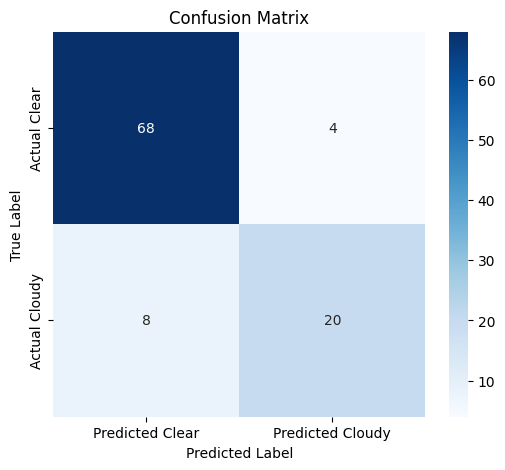

Classification Report:
              precision    recall  f1-score   support

       Clear       0.89      0.94      0.92        72
      Cloudy       0.83      0.71      0.77        28

    accuracy                           0.88       100
   macro avg       0.86      0.83      0.84       100
weighted avg       0.88      0.88      0.88       100

Final Test Accuracy: 88.00%


In [22]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import os

BEST_MODEL_PATH = "best_model.pth"
if os.path.exists(BEST_MODEL_PATH):
    model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=DEVICE))
    model.to(DEVICE)
    print("Best model loaded successfully.")
else:
    print("Error: best_model.pth not found!")

model.eval()


true_labels = []
predicted_labels = []

with torch.no_grad():
    for batch in test_loader:
        images = batch["image"].to(DEVICE)
        labels = batch["label"].cpu().numpy()  

        outputs = model(images)
        predicted = (outputs.cpu().numpy().flatten() > 0.5).astype(int)  
        
        true_labels.extend(labels)  
        predicted_labels.extend(predicted.squeeze())  

true_labels = np.array(true_labels).flatten()
predicted_labels = np.array(predicted_labels).flatten()

conf_matrix = confusion_matrix(true_labels, predicted_labels)


plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g',
            xticklabels=['Predicted Clear', 'Predicted Cloudy'],
            yticklabels=['Actual Clear', 'Actual Cloudy'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=['Clear', 'Cloudy']))


accuracy = np.mean(true_labels == predicted_labels) * 100
print(f"Final Test Accuracy: {accuracy:.2f}%")
